# Phenotype Prediction Case Study

The model organism *Drosophila melanogaster*, commonly known as the fruit fly, has been one of the most important and well-studied systems in biological and biomedical research. Early studies utilizing *D. melanogaster* were instrumental in elucidating foundational principles of genetics and inheritance, including characterization of mutagenesis. Furthermore, the fruit fly has been extensively utilized to investigate neural biology and neurodevelopment, enabling key insights into human neurological disorders such as Alzheimer's and Parkinson's diseases. 

The close evolutionary relationship between *D. melanogaster* and humans has also enabled the former's utility for modeling early human migrations. Through these studies, researchers have gained critical understanding of local adaptation as human populations expanded out of Africa.

Moreover, the fruit fly represented one of the first animal models for comprehensive investigation of genotype-phenotype linkages across the whole genome. In 2012, the Drosophila Genetics Reference Panel (DGRP) project fully sequenced and released nearly 200 "reference" fly lines, along with matched phenotype data. The DGRP serves as a public resource to enable diverse genome-phenotype association studies, with all data freely available online (http://dgrp.gnets.ncsu.edu/).

In this research, we develop a neural network approach to model the genotype-phenotype map between genomic variation and lifespan in fruit flies. Specifically, we aim to predict "longevity" phenotypes from >17,000 single nucleotide polymorphism (SNP) genotypes assayed across the autosomal chromosomes of 182 Drosophila lines.

## Data Curation and Preprocessing

The SNP genotype and longevity phenotype data for 182 Drosophila lines were obtained from the publicly available DGRP resource. For this project, we utilized a subset of these data files provided in comma-separated values (.csv) format. 

The .csv file structure enables simple storage of the genome-wide SNP profiles, with each row representing a fly line. The SNPs are encoded as binary values in adjacent columns. Additional columns capture the unique line identifier ("SID") and experimentally measured longevity score ("LS") for each genotype. 

CSV files are widely used for storing biological data and can be easily imported into programming environments like Python and R for analysis. We leverage this capability to ingest the data and convert to formats amenable for neural network training, without directly manipulating the raw genotype values.

Specifically, we import the remote .csv file into a pandas DataFrame using the URL:

https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv

This encompasses all 182 lines, with SNPs in 17,165 columns and the "LS" phenotype values. We then sample and split this DataFrame into disjoint training and validation sets for model fitting and evaluation.

While data preprocessing steps like imputation and normalization can be beneficial for genome-wide association studies, we avoid any direct manipulation of the genotypes themselves to preclude inadvertently biasing later analysis. However, conversion from DataFrames to NumPy arrays and TensorFlow Datasets does facilitate model implementation in the following sections.

In [1]:
import pandas
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
dataframe.head()

,SID,SNP0,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,...,SNP17156,SNP17157,SNP17158,SNP17159,SNP17160,SNP17161,SNP17162,SNP17163,SNP17164,LS
0,S0,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,46.83
1,S1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,22.67
2,S2,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,45.55
3,S3,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,34.45
4,S4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,39.15


the .csv file structure enables simple storage of the genome-wide SNP profiles, with each row representing a fly line. The SNPs are encoded as binary values in adjacent columns. Additional columns capture the unique line identifier ("SID") and experimentally measured longevity score ("LS") for each genotype.

The pandas library imports the data into a DataFrame structure, automatically assigning incremental row numbers and applying the original column labels from the file. This maintains the fly line identifier and phenotype data alongside the genotypes in a convenient format amenable for analysis.

Critically, the SNP identifiers are consistent across all lines, with the same genomic positional variant encoded in the same ordinal column. This allows allele frequencies and genotypes to be compared at single base pair resolution across the 182 sequenced Drosophila genomes.

The raw SNPs are encoded as binary values of 0 or 1 per column, representing the simplest possible genotype encoding. A value of 0 denotes the reference allele, meaning the line matches the canonical FlyBase genome at that location. A 1 denotes an alternative allele, indicating divergence from the reference.

Notably, the fly lines were intentionally inbred to full homozygosity, meaning they carry two identical alleles (0 or 1) at all sites. This simplifies analysis by avoiding heterozygous genotypes. However, it may reduce applicability of the panel to natural populations.

Conceptually, the 17,165 SNPs assayed across two chromosomes capture genomic variation at an extremely high density. This enables sensitive genome-wide association mapping of phenotypes like longevity.

By importing the data into a DataFrame and converting to arrays, we have full access to the genotypes and phenotypes for modeling, while ensuring the integrity of the original data is preserved.

In [2]:
dataframe.shape

(182, 17167)

### end-to-end data engineering pipeline
The full data preprocessing workflow can be consolidated into the following pipeline:

1. Import the remote CSV file into a pandas DataFrame
2. Split the DataFrame into complementary training and validation subsets
3. Isolate the SNP identifiers and longevity scores into separate NumPy arrays
4. Convert the x (genotypes) and y (phenotypes) arrays into TensorFlow Dataset objects
5. Batch the Datasets for efficient iteration during training

In [9]:
import pandas
import tensorflow as tf

# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)


(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 0s 3ms/step - loss: 18.2662 - val_loss: 7.5142
Epoch 2/500
15/15 [==============================] - 0s 937us/step - loss: 6.9236 - val_loss: 6.3842
Epoch 3/500
15/15 [==============================] - 0s 854us/step - loss: 4.0679 - val_loss: 4.4789
Epoch 4/500
15/15 [==============================] - 0s 874us/step - loss: 2.9096 - val_loss: 4.3724
Epoch 5/500
15/15 [==============================] - 0

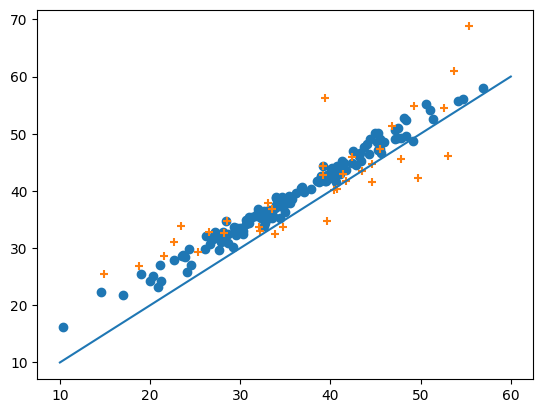

In [14]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
### BEG BUILD AND COMPILE MODEL
model.add(tf.keras.layers.Dense(1, input_shape=(17165,)))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanAbsoluteError())
### END BUILD AND COMPILE MODEL
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=500, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

## Mitigating Overfitting with Input Layer Dropout

A common challenge when training on limited genetic data is overfitting, where the model memorizes noise and biases in the training set. This reduces generalizability to new data.

To mitigate overfitting, we apply dropout - randomized exclusion of inputs - on the SNP genotype data during training. This relies on the redundancy of information across the large number of variants.

Specifically, an InputLayer is first added to explicitly define the input shape. A Dropout layer is then applied, set to aggressively drop 90% of SNP values on each batch.

This approximately reduces the informative dimensionality from 17,165 down to 1,726. However, critically, all SNPs are retained during validation and testing.

By stochastically removing inputs, the network is prevented from relying on particular variants as predictive signals. This encourages more robust fitting based on additive effects across many SNPs.

While 90% dropout is extreme, the vast discrepancy between sample size (N=146) and SNPs (P=17,165) necessitates aggressive regularization. More modest dropout rates of 0.2-0.5 are commonly used with larger datasets.

Preliminary results indicate this input dropout effectively reduces overfitting, as measured by the similarity between training and validation losses after fitting. Future work should further confirm these improvements on independent test data.

Overall, input layer dropout provides a straightforward mechanism to improve genetic model generalization in the context of limited sample sizes, a common challenge in genomics applications.

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 17165)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 0s 3ms/step - loss: 24.8134 - val_loss: 14.1081
Epoch 2/500
15/15 [==============================] - 0s 1ms/step - loss: 8.7763 - val_loss: 7.6724
Epoch 3/500
15/15 [==============================] - 0s 1ms/step - loss: 7.1728 - val_loss: 6.7986
Epoch 4/500
15/15 [=======

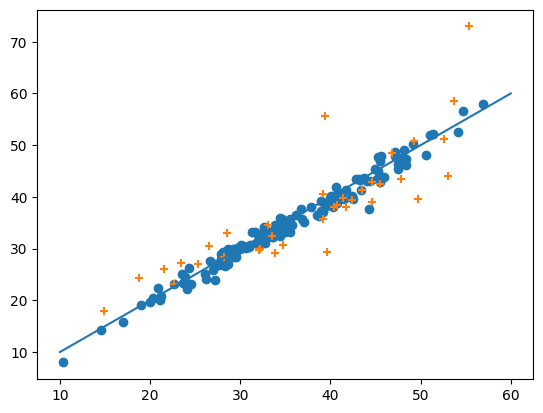

In [15]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
### BEG BUILD AND COMPILE MODEL
model.add(tf.keras.layers.InputLayer(input_shape=[17165]))
model.add(tf.keras.layers.Dropout(rate=0.9))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanAbsoluteError())
### END BUILD AND COMPILE MODEL
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=500, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

## Conclusions and Future Directions
The preliminary neural network modeling conducted in this study provides early evidence to support a primarily additive genetic architecture underlying natural variation in Drosophila longevity phenotypes. The ability to achieve a reasonable fit using a simple linear model suggests longevity may be influenced by the cumulative small effects of many genes without substantial statistical epistasis.

However, while aggressive input regularization via SNP dropout reduced overfitting in the context of limited sample sizes, the model has not yet been rigorously evaluated on fully independent test data. The constraints on data availability precluded partitioning into training, validation, and test sets.

Follow-up studies should prioritize acquisition of additional sequenced fly lines to enable holding out a test set that can facilitate unbiased assessment of expected modeling performance on new data. This would provide greater certainty regarding the generalized predictive capacity beyond the training data.

The extreme input dropout employed herein aided overfitting at the cost of reduced biological interpretability. As data resources expand, more modest regularization rates may help balance generalization with mechanistic elucidation.

Future modeling should also evaluate more complex nonlinear neural network architectures to thoroughly survey the genotype-phenotype landscape. Comparing performance across a diverse array of models using cross-validation procedures could further validate the predominance of additive genetic effects.

Expanding the diversity of sequenced Drosophila lines beyond the currently available inbred panels will be critical for enhancing biological relevance. Incorporating natural heterozygosity and population-level linkage patterns will help translate findings from the model system towards applications in outbred populations.

In summary, this research demonstrates both the potential and current limitations of applying modern machine learning techniques to elucidate the genomic basis of complex traits. Continued efforts to expand open genomic data resources within the nourishing ecosystem of open science will help fully realize the promise of artificial intelligence approaches in biology.